In [5]:
from functions_class import W, dW, compute_rho, compute_pressure
from functions_class import compute_gradient, time_advance, recenter, get_min_dt, plot_3D

In [6]:
import numpy as np
import math
from math import sqrt
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from numba import jit
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots
from IPython.display import clear_output
from ipywidgets import FloatProgress
from IPython.display import display


## Particle definition

In [7]:
class particle:
    m=1.6726219e-27 #mass (kg)
    rho=0 #density (kg/m^3)
    P=0 #pressure (Pa)
    x=0 #location (m)
    v=0 #speed (m/s)
    rho_0=0 #reference density (kg/m^3)
    K0=0 #reference adiabat 
    alpha=0 #smoothing width (m)
    aindex=5/3.

In [12]:
def weighthed_radius(m, x, y, z):
    r = (x**2 + y**2 + z**2)**(1/2)
    rm = r * m 
    wtd_r = np.sum(rm)/ np.sum(m)
    return wtd_r

def avg_radius(m, x, y, z):
    r = (x**2 + y**2 + z**2)**(1/2)
    r_mean, r_err = np.mean(r), np.std(r)
    return r_mean, r_err

In [79]:
def plot_2D(particles,t=0):
    global length
    fig=plt.figure(figsize=(20,20))
    ax=fig.add_subplot(2,2,1)
    ax.set(xlim=(-length/2,length/2),ylim=(-length/2,length/2))
    n=len(particles)
    data_x=np.zeros(n)
    data_y=np.zeros(n)
    data_z=np.zeros(n)
    data_m=np.zeros(n)
    data_rho =np.zeros(n)
    data_vx,data_vy, data_vz =np.zeros(n), np.zeros(n), np.zeros(n)
    
    for i in range(n):
        data_x[i]=particles[i].x[0]
        data_y[i]=particles[i].x[1]
        data_z[i]=particles[i].x[2]        
        data_m[i]=particles[i].m
        data_vx[i]=particles[i].v[0]
        data_vy[i]=particles[i].v[1]
        data_vz[i]=particles[i].v[2]
        data_rho[i]= particles[i].rho
    
    #     a = [data_x, data_y, data_z, data_m, data_vx,data_vy, data_vz ]  
    wtd_r = weighthed_radius(data_m, data_x, data_y, data_z)
    wtd_v = weighthed_radius(data_m, data_vx, data_vy, data_vz)
    
    r = (data_x**2+data_y**2+data_z**2)**(1/2)
    v =  (data_vx**2+data_vy**2+data_vz**2)**(1/2)
    
    R, v = np.abs(r- wtd_r), np.abs(v-wtd_v)
    
    ax.scatter(data_x,data_y,c=np.log(data_m), cmap=plt.cm.Wistia, 
               s=40, alpha=0.75)
    ax.set_facecolor('black')
    ax.set_xlabel("x",fontsize=15)
    ax.set_ylabel("y",fontsize=15)
    ax.set_box_aspect(1)
    ax.tick_params('y', labelsize=12)
    ax.tick_params('x', labelsize=12)

    #####
    ax=fig.add_subplot(2,2,2)
    ax.set(xlim=(-length/2,length/2),ylim=(-length/2,length/2))
    ax.scatter(data_x,data_z,c=np.log(data_m), cmap=plt.cm.Wistia, 
               s=40, alpha=0.75)
    ax.set_xlabel("x",fontsize=15)
    ax.set_ylabel("z",fontsize=15)
    ax.set_box_aspect(1)
    ax.set_facecolor('black')
    ax.tick_params('y', labelsize=12)
    ax.tick_params('x', labelsize=12)
    
    ######
    ax=fig.add_subplot(2,2,3)
#     ax.set(xlim=(-length/2,length/2),ylim=(-length/2,length/2))
    im = ax.scatter(r, data_rho, alpha=0.75)
#                     , c=np.log(data_rho))
#     fig.colorbar(im, ax=ax)
    ax.set_xlabel(r"$|r-r_{cm}|$ (m)",fontsize=15)
    ax.set_ylabel(r"$\rho$ (kg/m^3)",fontsize=15)
    ax.tick_params('x', labelrotation=90, labelsize=12)
    ax.tick_params('y', labelsize=12)    
    ax.set_yscale('linear')

    ax.set_box_aspect(1)
#     ax.set_facecolor('black')
    
    #######
    ax=fig.add_subplot(2,2,4)
#     ax.set(xlim=(-length/2,length/2),ylim=(-length/2,length/2))
    im = ax.scatter(r, data_rho, alpha=0.75)
#                     , c=np.log(data_rho))
#     fig.colorbar(im, ax=ax)
    ax.set_xlabel(r"$|r-r_{cm}|$ (m)",fontsize=15)
    ax.set_ylabel(r"$\rho$ (kg/m^3)",fontsize=15)
    ax.tick_params('x', labelrotation=90, labelsize=12)
    ax.tick_params('y', labelsize=12)
    ax.set_yscale('log')

    ax.set_box_aspect(1)
    plt.suptitle(str(t))
    
    if round(t, 1) in [0.1, 1, 2, 3, 4, 5, 6, 7, 8]:
        string = 'secondtry_t{}.png'.format(t)
        plt.savefig(string, dpi=300)
    
    show_inline_matplotlib_plots()
    clear_output(wait=True)
    
#     return a

## Our initial conditions

In [75]:
ti=0
tf=8
t=0
n_out=100
t_out=(tf-ti)/n_out
t_print=0
length=1e6
G=6.67408e-11
nu=1.5

## Define our particle types

In [76]:
domain=np.array([-length,length,-length,length,-length,length])
box=domain*.85
cp=np.empty(0,dtype=object)
N_total=100000
Nc=200 # the number of particle clumps (also called particles herein)
Np=max(int(N_total/Nc),1) # the number of particles per clump
M=0
for i in range (Nc):
    cp=np.append(cp,particle()) # we load the particles
    cp[i].K0=1* 10e4 # adiabatic reference 1 - 10
    cp[i].rho0=Np*8300 
    if (i%4==0): ## change the composition here i%4==0 means that 25% of the particles are the heavy ones
        cp[i].rho0*=1
    if (i%4==1): 
        cp[i].rho0*=2
    if (i%4==2): 
        cp[i].rho0*=4
    if (i%4==3): 
        cp[i].rho0*=8
    
    cp[i].alpha=1e5 # changes shape of radial distribution
    cp[i].x=np.zeros(3)
    r=length*(0.5-np.random.random_sample()*.25)
    theta=np.pi*np.random.random_sample()
    phi=2*np.pi*np.random.random_sample()
    cp[i].x[0]=r*np.cos(phi)*np.sin(theta)
    cp[i].x[1]=r*np.sin(phi)*np.sin(theta)
    cp[i].x[2]=r*np.cos(theta)
    cp[i].v=np.zeros(3)
    cp[i].m=cp[i].rho0*4/3*np.pi*cp[i].alpha**3
    M+=cp[i].m
print('planet mass '+str(M)+'kg')

planet mass 1.3037609512397673e+25kg


In [77]:
# normalisation to get earth's mass

M0 = 6e+24
Mold = M

domain=np.array([-length,length,-length,length,-length,length])
box=domain*.85
cp=np.empty(0,dtype=object)
N_total=100000
Nc=200 # the number of particle clumps (also called particles herein)
Np=max(int(N_total/Nc),1) # the number of particles per clump
M=0
for i in range (Nc):
    cp=np.append(cp,particle()) # we load the particles
    cp[i].K0=1* 10e4 # adiabatic reference 1 - 10
    cp[i].rho0=Np*8300 * (M0/ Mold)# density. Two rho0 means there are two layers
    if (i%4==0): ## change the composition here i%5==0 means that 20% of the particles are the heavy ones
        cp[i].rho0*=1
    if (i%4==1): ## change the composition here i%5==0 means that 20% of the particles are the heavy ones
        cp[i].rho0*=2
    if (i%4==2): ## change the composition here i%5==0 means that 20% of the particles are the heavy ones
        cp[i].rho0*=4
    if (i%4==3): ## change the composition here i%5==0 means that 20% of the particles are the heavy ones
        cp[i].rho0*=8
    
    cp[i].alpha=1e5 # changes shape of radial distribution
    cp[i].x=np.zeros(3)
    r=length*(0.5-np.random.random_sample()*.25)
    theta=np.pi*np.random.random_sample()
    phi=2*np.pi*np.random.random_sample()
    cp[i].x[0]=r*np.cos(phi)*np.sin(theta)
    cp[i].x[1]=r*np.sin(phi)*np.sin(theta)
    cp[i].x[2]=r*np.cos(theta)
    cp[i].v=np.zeros(3)
    cp[i].m=cp[i].rho0*4/3*np.pi*cp[i].alpha**3
    M+=cp[i].m
print('planet mass '+str(M)+'kg')

planet mass 5.999999999999978e+24kg


0.1


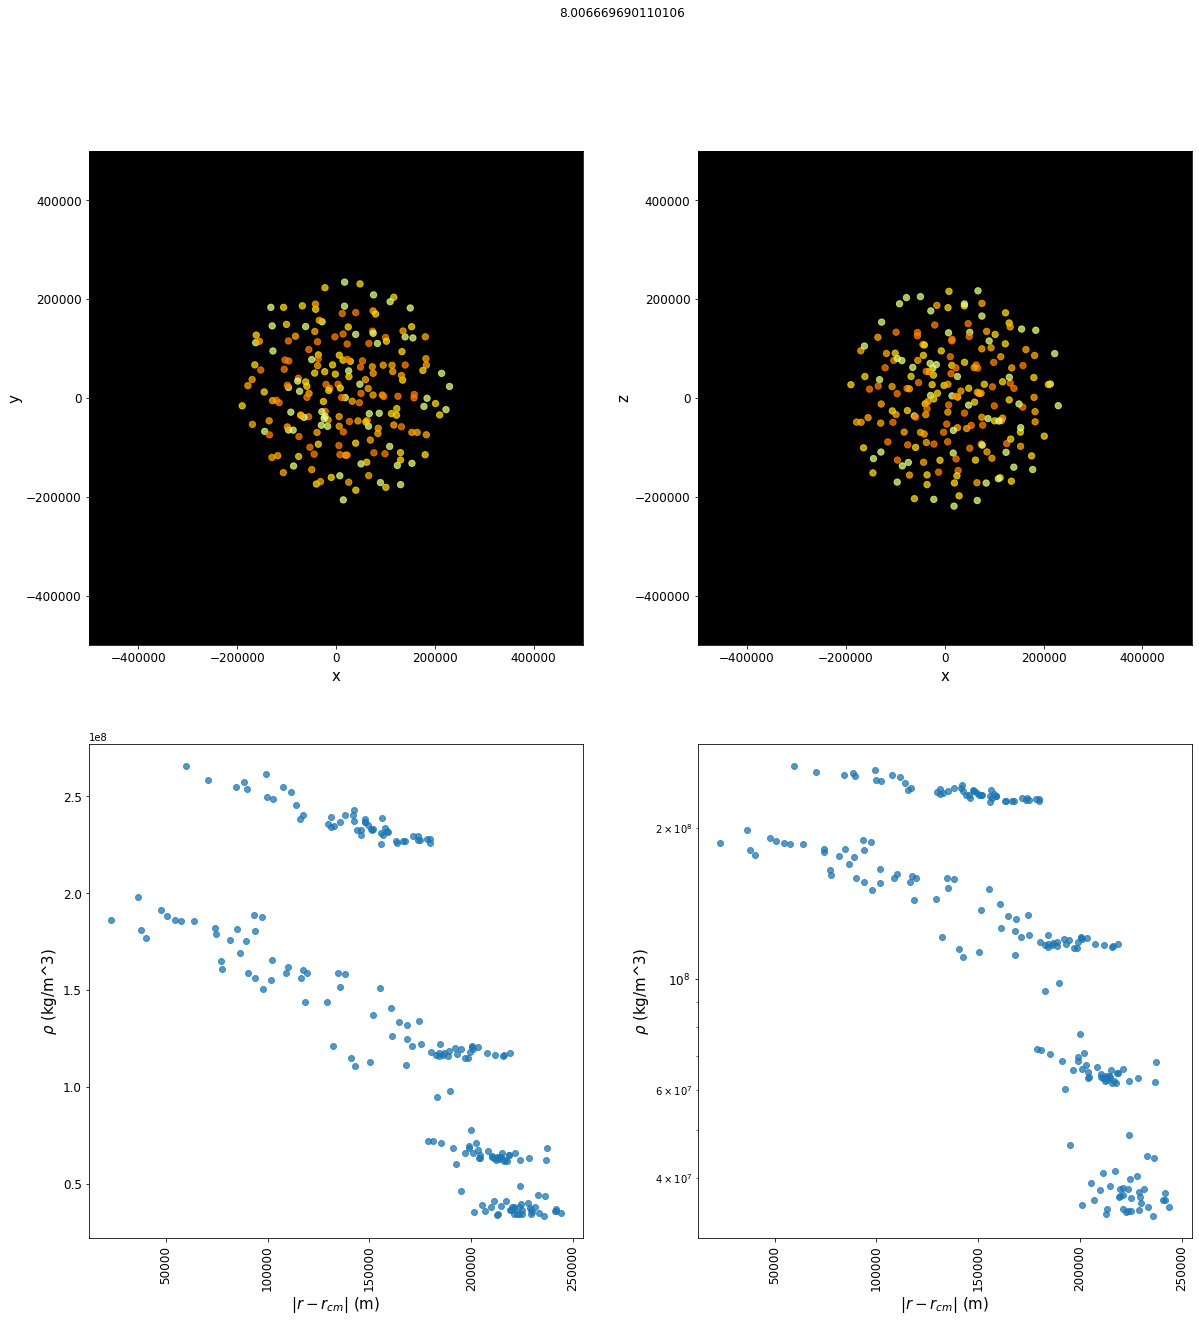

In [78]:

from matplotlib import interactive
interactive(False)
%matplotlib inline
t=0
dt=.1
print(dt)
while (t<tf):
    print(dt)
    compute_rho(cp)
    compute_pressure(cp)
    grad=compute_gradient(cp)
    time_advance(cp,grad,dt=dt)
    compute_rho(cp)
    compute_pressure(cp)
    grad=compute_gradient(cp)
    time_advance(cp,grad,dt=dt,x_adv=0)
    dt=get_min_dt(cp)
    t+=dt
    t_print+=dt
    plot_2D(cp,t)